# Race Data Analysis

Goal of this notebook is to get some insight into some Race Data. Its from four different race tracks of different drivers splitted into 42 xml files with a total of 283mB. The Data itself is confidential, so only small snippets of the raw data will be shown.

## 1.) Data Gathering

From the Folderstructure we know there are four different tracks each with a different number of races. One Race per File.
Each file contains Trackpoints for several laps. The first lap of each track is a warmup round without actual data. Per Trackpoint the following data is provided: 

* GPS coordinates
* Heading
* Distance driven
* altitude above sea level
* several sensor data

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import operator
import glob
import xml.etree.ElementTree as ET
import pandas as pd
import copy
import seaborn as sns

Form Panda Dataframe from given XML files


In [17]:
import glob
import xml.etree.ElementTree as ET
namespace = "{http://www.topografix.com/GPX/1/1}"
root_dir = './GPX Files\\'

#data should look like this, so it can be converted to pandas dataframe:
data = []
#dict to store race info like circuitname lap etc.
raceinfo = {"circuitname": "", "racenumber": -1, "lapCounter":0, "tracklength": 0}
for filename in glob.iglob(root_dir + '**/*.gpx', recursive=True):
    
    #if FileName is Track: Skip
    if 'Track' in str(filename):
        continue
        
    print ('currentFile', filename)
    
    currentcircuitname = filename.split(root_dir)[1].split("\\")[0]
    #racefilename = filename.split(root_dir)[1].split("\\")[1]

    # reset racenumber on new type of circuit
    if currentcircuitname != raceinfo["circuitname"]:
        raceinfo["racenumber"] = 1
        raceinfo["circuitname"] = currentcircuitname
                
    # reset laps
    raceinfo["lapCounter"] = 0
        
    root = ET.parse(filename).getroot()
    
    #RaceDriver Id and Name
    raceMeta = root.find (namespace + "metadata").find(namespace + "extensions").find(namespace + "raceMeta")
    userProfileName = None
    userProfileGUID = None
    for amgraw in raceMeta.findall("*"):
        amg = str(amgraw).split("{https://www.mercedes-amg.com/xsd/gpx-ext}")[1].split('\'')[0]
        if amg == "userProfileName":
            userProfileName = str(amgraw.text)
        elif amg == "userProfileGUID":
            userProfileGUID = str(amgraw.text)
            
    #track length
    trackmeta = root.find (namespace + "metadata").find(namespace + "extensions").find(namespace + "trackMeta")
    for amgraw in trackmeta.findall("*"):
        amg = str(amgraw).split("{https://www.mercedes-amg.com/xsd/gpx-ext}")[1].split('\'')[0]
        if amg == "length":
            raceinfo["tracklength"] = str(amgraw.text)
        
    raceinfo["userProfileName"] = userProfileName
    raceinfo["userProfileGUID"] = userProfileGUID
        
    for lap in root.findall(namespace + "trk"):
        #first <trk>(=fist lap) is only general trackdata and is not needed
        if raceinfo["lapCounter"] > 0:
            #get AverageLapSpeed in kmh and Top Speed  in kmh + Laptime in ms
            averageLapSpeed = float(lap.find(namespace + "extensions").find(namespace + "lapAverageSpeed").text)/10
            topLapSpeed = float(lap.find(namespace + "extensions").find(namespace + "lapTopSpeed").text)/10
            lapTime = float(lap.find(namespace + "extensions").find(namespace + "lapTime").text)/1000
            
            raceinfo["segCounter"] = 1
            for seg in lap.findall(namespace +"trkseg"):
                for trkpt in seg.findall(namespace + "trkpt"):
                    #add race data
                    current_trkpt_data = copy.deepcopy(raceinfo)
                    #add lap data
                    current_trkpt_data["averageLapSpeed"] = averageLapSpeed
                    current_trkpt_data["topLapSpeed"] = topLapSpeed
                    current_trkpt_data["lapTime"] = lapTime
                    #copy trackpoint attributes
                    current_trkpt_data.update(trkpt.attrib)
                    #copy tags of trackpint
                    for tag in trkpt.find(namespace + "extensions").findall("*"):
                        key = str(tag).split(namespace)[1].split("'")[0]
                        value = tag.text
                        current_trkpt_data[key] = value
                    #add to data
                    data.append(copy.deepcopy(current_trkpt_data))
                raceinfo["segCounter"]+=1
        raceinfo["lapCounter"]+=1
    raceinfo["racenumber"]+=1
    print("total datapoints: " + str(len(data)))


currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171204T093133.gpx
total datapoints: 5638
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T074157.gpx
total datapoints: 33191
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T110519.gpx
total datapoints: 58810
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171205T131202.gpx
total datapoints: 84760
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171207T130651.gpx
total datapoints: 108741
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171208T081031.gpx
total datapoints: 119775
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T125620.gpx
total datapoints: 132088
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T144140.gpx
total datapoints: 135814
currentFile ./GPX Files\Circuit Ricardo Tormo unofficial\Race_20171209T153538.gpx
total datapoints: 137882
currentFile ./GPX Files\Circuit Ricardo To

In [21]:
df = pd.DataFrame(data)

In [22]:
df.shape

(265357, 142)

## 2.) Data Exploration: Lets get some overview

In [24]:
#number of races and segments per circuitname

In [25]:
df_overview_0 = df[['circuitname', 'racenumber', 'segCounter']].groupby('circuitname').max()
df_overview_0

,racenumber,segCounter
circuitname,,
Circuit Ricardo Tormo unofficial,15,3
Circuito del Jarama,3,1
Idiada Handling,5,1
Sachsenring,15,3


In [26]:
#number of total laps per circuitname
df_lapcounter = df[['circuitname', 'racenumber','lapCounter']].groupby(['circuitname','racenumber']).max(['lapCounter']) \
.groupby('circuitname').sum()
df_overview_1 = df_overview_0.copy()
df_overview_1["total laps"] = df_lapcounter
df_overview_1

,racenumber,segCounter,total laps
circuitname,,,
Circuit Ricardo Tormo unofficial,15,3,91
Circuito del Jarama,3,1,5
Idiada Handling,5,1,25
Sachsenring,15,3,43


In [27]:
#number of total trackpoints per circuitname
df_total_trackpoints = df['circuitname'].value_counts().to_frame('trackpoints')
df_overview_2 = df_overview_1.copy()
df_overview_2["total_trackpoints"] = df_total_trackpoints
df_overview_2

,racenumber,segCounter,total laps,total_trackpoints
circuitname,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087
Circuito del Jarama,3,1,5,6091
Idiada Handling,5,1,25,17270
Sachsenring,15,3,43,50909


In [28]:
#mean number of trackpoints per lap
df_mean_number_of_trackpoints_per_lap= df[['circuitname', 'racenumber','lapCounter']].\
groupby(['circuitname','racenumber','lapCounter']).size().groupby("circuitname").mean().to_frame("mean trackpoint/lap")
df_mean_number_of_trackpoints_per_lap = df_mean_number_of_trackpoints_per_lap.reset_index()

df_overview_3 = df_overview_2.copy()
df_overview_3["mean trackpoint/lap"] = list(df_mean_number_of_trackpoints_per_lap["mean trackpoint/lap"])
df_overview_3


,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap
circuitname,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143
Circuito del Jarama,3,1,5,6091,1218.200000
Idiada Handling,5,1,25,17270,690.800000
Sachsenring,15,3,43,50909,1183.930233


In [29]:
#circuit lenght and mean meters/ trackpoint
df_length = df[['circuitname','tracklength']].groupby(['circuitname','tracklength']).max()[:4]
df_length=df_length.reset_index()
df_overview_4 = df_overview_3.copy()
df_overview_4["tracklength"] = list(df_length["tracklength"])
df_overview_4["tracklength"] = df_overview_4["tracklength"].astype(float, errors = 'raise')
df_overview_4

,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap,tracklength
circuitname,,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143,3959.47
Circuito del Jarama,3,1,5,6091,1218.200000,3850.37
Idiada Handling,5,1,25,17270,690.800000,2148.52
Sachsenring,15,3,43,50909,1183.930233,3572.85


In [30]:
df_overview_4['mean meter per trackpoint'] = df_overview_4['tracklength'] / df_overview_4["mean trackpoint/lap"]
df_overview_4

,racenumber,segCounter,total laps,total_trackpoints,mean trackpoint/lap,tracklength,mean meter per trackpoint
circuitname,,,,,,,
Circuit Ricardo Tormo unofficial,15,3,91,191087,2099.857143,3959.47,1.885590
Circuito del Jarama,3,1,5,6091,1218.200000,3850.37,3.160704
Idiada Handling,5,1,25,17270,690.800000,2148.52,3.110191
Sachsenring,15,3,43,50909,1183.930233,3572.85,3.017788


### 2.1) Lap-times

Lets find out about the laptimes per Lap per circuit.

<AxesSubplot:title={'center':'Lap times for Circuit Ricardo Tormo unofficial'}>

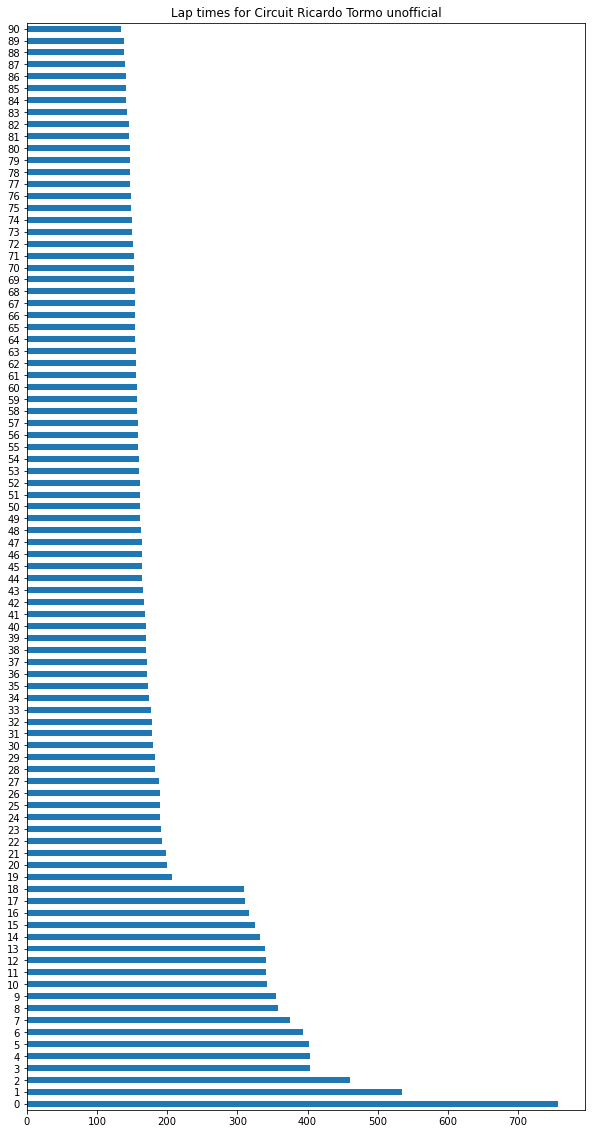

In [31]:
df_laptimes = df[["circuitname","racenumber","lapCounter", "lapTime"]].groupby(["circuitname","racenumber","lapCounter"]).max()
df_laptimes=df_laptimes.reset_index()

df_laptime_1 =df_laptimes.loc[df_laptimes['circuitname'] == "Circuit Ricardo Tormo unofficial"].sort_values("lapTime")
df_laptime_1 = df_laptime_1[::-1]
df_laptime_1.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,20), title = "Lap times for Circuit Ricardo Tormo unofficial")

<AxesSubplot:title={'center':'Lap times for Circuito del Jarama'}>

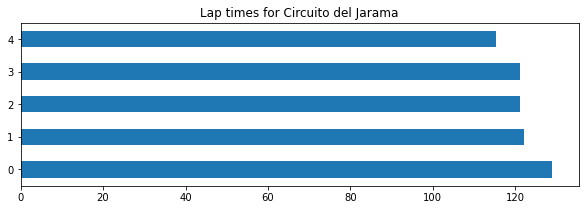

In [32]:
df_laptime_2 =df_laptimes.loc[df_laptimes['circuitname'] == "Circuito del Jarama"].sort_values("lapTime")
df_laptime_2 = df_laptime_2[::-1]
df_laptime_2.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,3), title = "Lap times for Circuito del Jarama")

<AxesSubplot:title={'center':'Lap times for Idiada Handling'}>

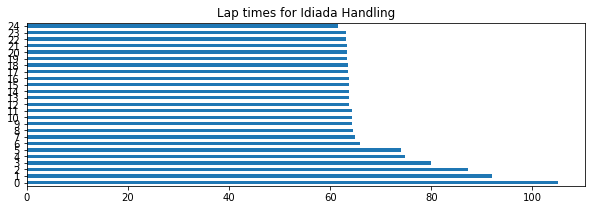

In [33]:
df_laptime_3 =df_laptimes.loc[df_laptimes['circuitname'] == "Idiada Handling"].sort_values("lapTime")
df_laptime_3 = df_laptime_3[::-1]
df_laptime_3.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,3), title = "Lap times for Idiada Handling")

<AxesSubplot:title={'center':'Lap times for Sachsenring'}>

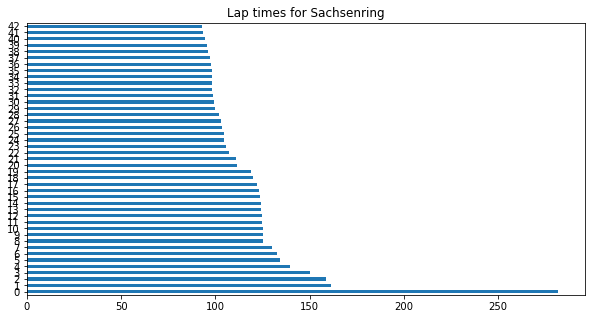

In [34]:
df_laptime_4 =df_laptimes.loc[df_laptimes['circuitname'] == "Sachsenring"].sort_values("lapTime")
df_laptime_4 = df_laptime_4[::-1]
df_laptime_4.reset_index()["lapTime"].\
plot.barh( x="lapTime",y="index",figsize=(10,5), title = "Lap times for Sachsenring")

### 2.2 Data Consistency

Some measurements are given for every Trackpoint some are only given for some Trackpoints. Lets get an intel.

<AxesSubplot:>

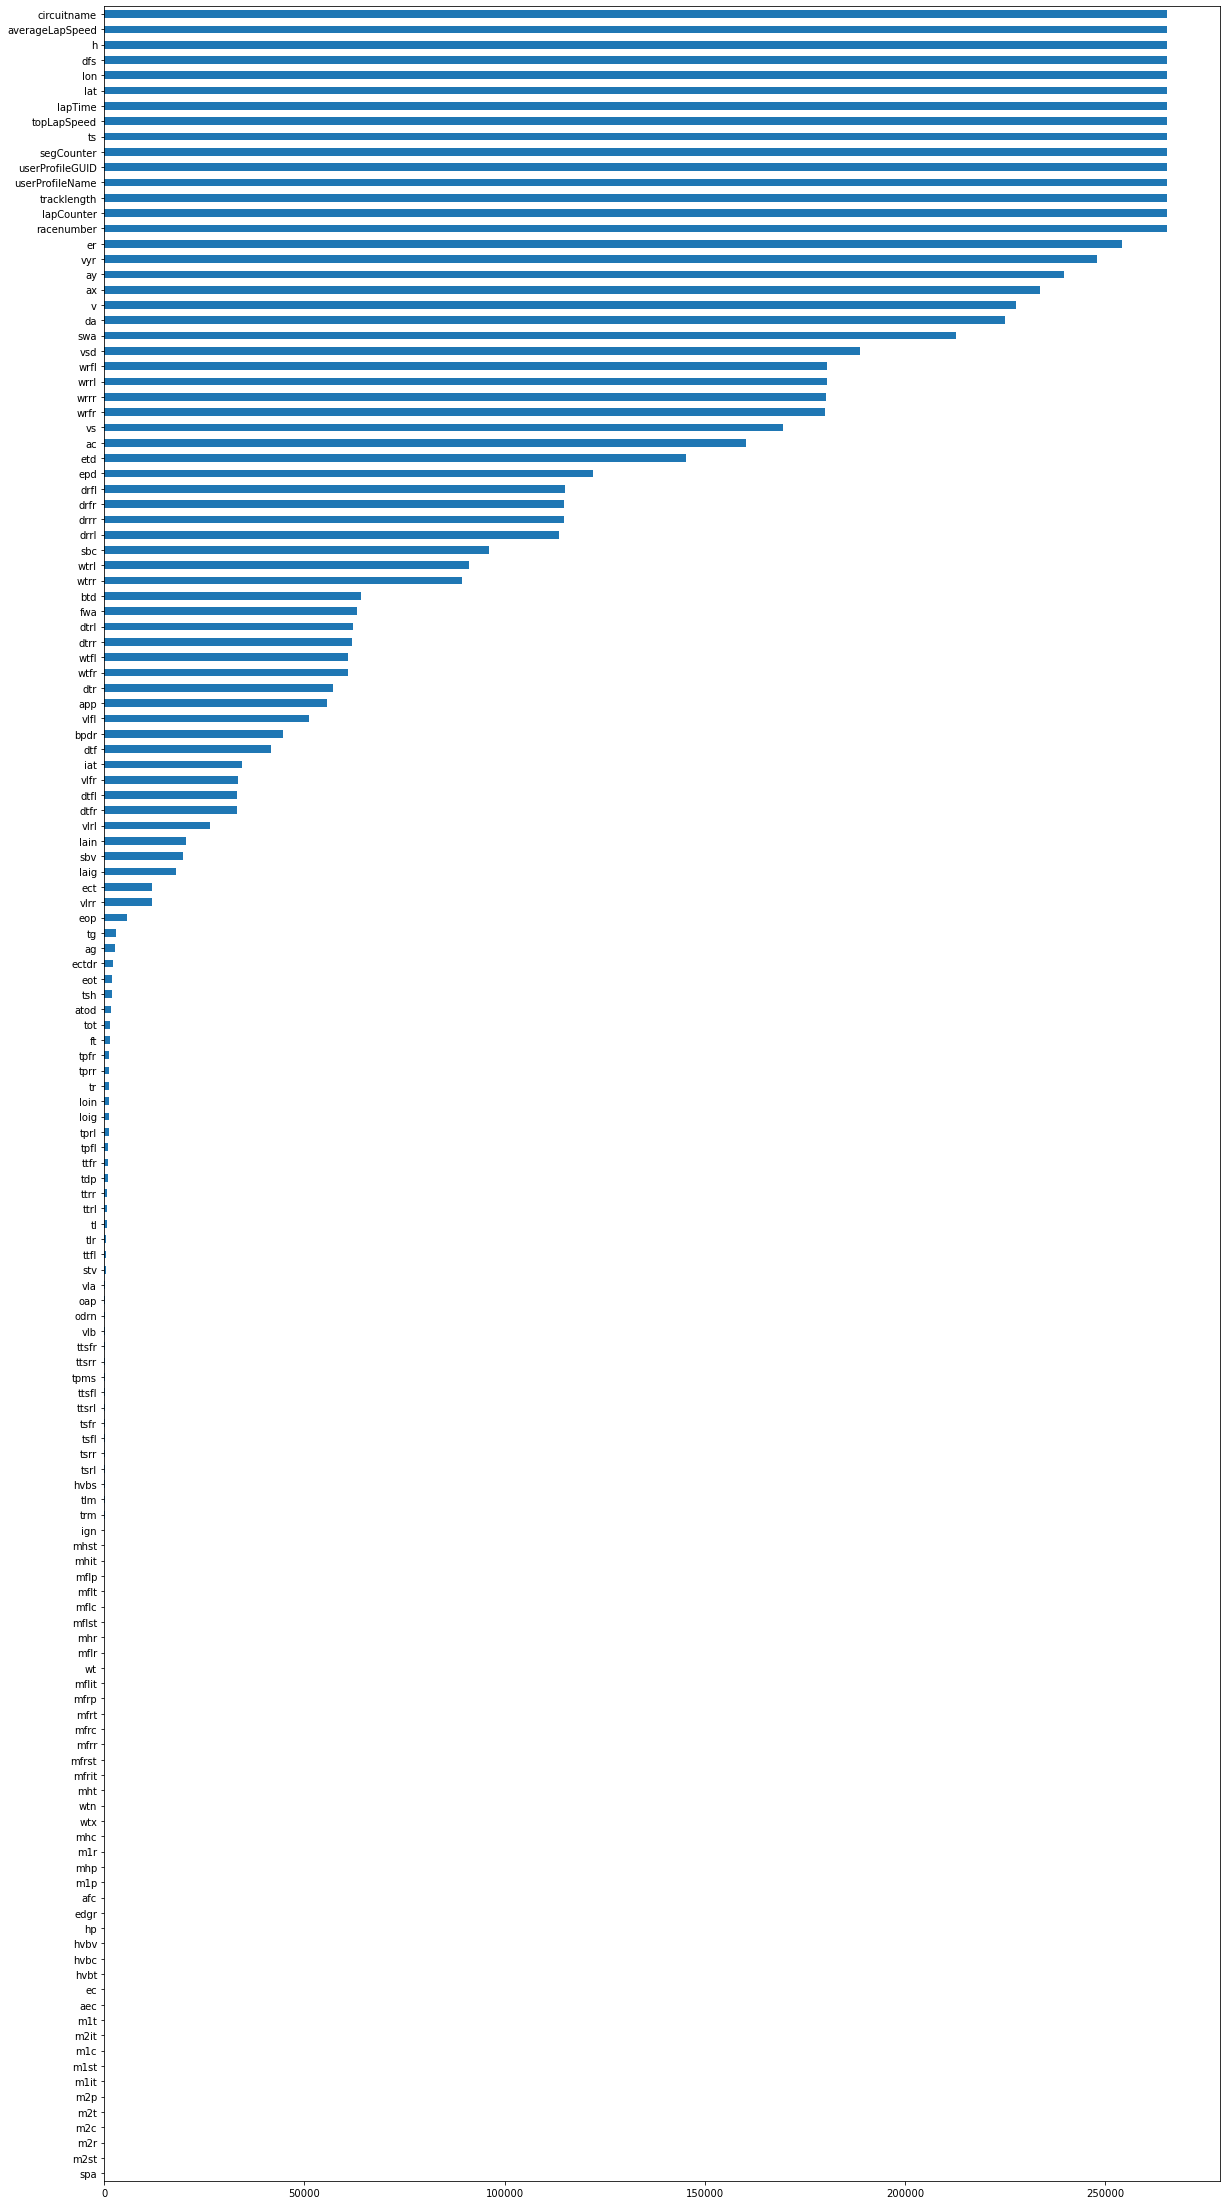

In [38]:
df_isnot_null = df.count()
df_isnot_null = df_isnot_null.sort_values()
df_isnot_null.plot.barh(x=1, y=0, figsize=(20,40))

In [36]:
(df_isnot_null == df_isnot_null.max()).sum()

15

15 Measurements are given for every Trackpoint. 127 are not given for every Trackpoint.

As we can see much data is not recorded for every Trackpoint. Lets check following important data:
- latitude
- longitude
- gear
- distance since start
- heading direction
- speed
- throttle
- braking torque
- steering angle

<AxesSubplot:ylabel='measurement'>

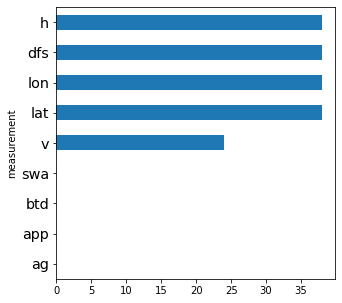

In [136]:
important_dataframe = df[['lat', 'lon', "ag", "dfs", "h", "v", "app", "btd", "swa", "circuitname", "racenumber"]] 
important_dataframe = important_dataframe.groupby(["circuitname", "racenumber"]).apply(lambda x: x.notnull().all())
del important_dataframe['racenumber']
del important_dataframe['circuitname']

important_dataframe_resettted =important_dataframe.reset_index(drop=True).sum().sort_values()
important_dataframe_resettted.plot.barh(figsize=(5,5),ylabel= "measurement")

heading, distance from start, longtitude, latitude are given for every trackpoint in all races. 

Speed is only complete for roughly 15 races.

Steering angle, braking torque, throttle and gear are not completely given for no race. 

### 2.3 Data Ranges

In [131]:
print("Distance from start has a range from " + str(df["dfs"].astype(float).min()) +\
      " to " + str(df["dfs"].astype(float).max()) + " metres.")
print("Heading has a range from " + str(df["h"].astype(float).min()) +\
      " to " + str(df["h"].astype(float).max()) + " degrees.")
print("Speed has a range from " + str(df["v"].astype(float).min()) + " to " + str(df["v"].astype(float).max())+ " metres per second.")
print("Gear has a range from " + str(df["ag"].astype(float).min()) + " to " + str(df["ag"].astype(float).max()))
print("Break Torque has a range from " + str(df["btd"].astype(float).min()) + " to " + str(df["btd"].astype(float).max())+ "Nm.")
print("steering wheel has a range from " + str(df["swa"].astype(float).min()/10) + " to " + str(df["swa"].astype(float).max()/10) + " degrees.")


Distance from start has a range from 0.0 to 3979.29 metres.
Heading has a range from 7.71935e-06 to 359.999 degrees.
Speed has a range from 0.0 to 80.7151 metres per second.
Gear has a range from 0.0 to 13.0
Break Torque has a range from 0.0 to 4890.0Nm.
steering wheel has a range from -353.2 to 409.2 degrees.


## 3.)Analysis 

### 3.1 Correlations

In [150]:
corr_df =df[['lat', 'lon', "ag", "dfs", "h", "v", "app", "btd", "swa"]]
corr_df = corr_df.apply(pd.to_numeric)
#interpolate missing values liner manner-wise
corr_df=corr_df.interpolate()

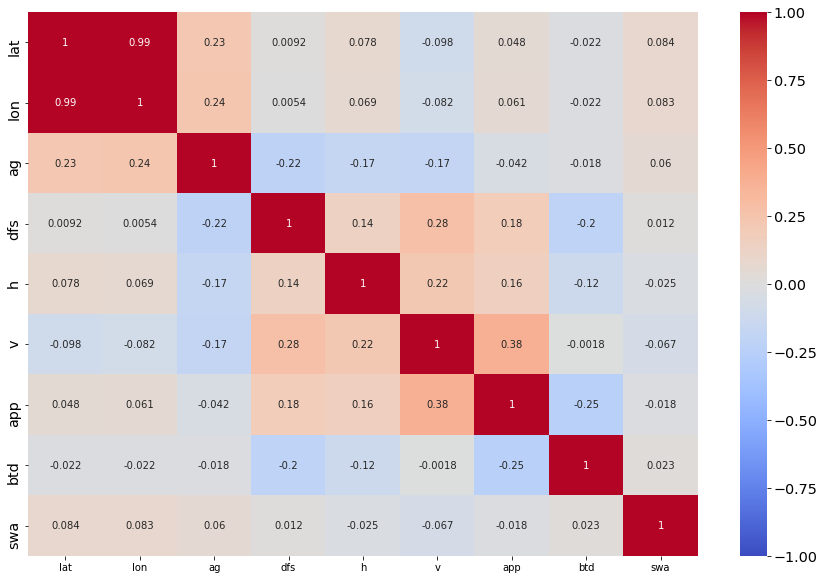

In [151]:
correlatedData = corr_df.corr()
plt.subplots(figsize=(30,20))
sns.heatmap(correlatedData, annot=True,cmap = 'coolwarm', vmin = -1)# ,vmin =-1, vmax=1

params = {
         'ytick.labelsize':'x-large'}

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.rcParams.update(params)


For example velocity(v) correlates with throttle(app) highly positive (0.38).

### 3.2) For some tableau plots we want to use the following features:

- circuitname
- racenumber
- lap
- segment
- lapTime
- userProfileGUID
- userProfileName
- speed: v
- topLapSpeed
- averageLapSpeed
- total metres driven: dfs
- time-stamp: ts
- lat
- lon

In [154]:
tableau_dataframe = df[['circuitname','racenumber','lapCounter','segCounter','userProfileGUID','userProfileName','lapTime','v', \
                                  'topLapSpeed','averageLapSpeed','dfs', 'ts', 'lat', 'lon']] 

In [10]:
#write to File
tableau_dataframe.to_csv('secondTask_data.txt', sep=';', index=False)

lets see the tableau plots:

![Dashboard1-image](Dashboard1.png "Dashboard 1")

![Dashboard2-image](Dashboard2.png "Dashboard 2")

This can be explained by the fact that driving uphill costs energy. A greater influence is probably the height difference of the race track in comparison to how the curves are located.

![Dashboard3-image](Dashboard3.png "Dashboard 3")